# Email Auto Fill
- **Text Preprocessing**
    - *Contractions, Sentence Tokenization*
- **Basic EDA**
    - *Word Cloud*
- **Probabilistic Language Models**
    - *Unigram, Bigrams, Trigrams, N-grams*

In [36]:
import numpy as np
import pandas as pd
import nltk, re, string, contractions
from nltk.tokenize import sent_tokenize, word_tokenize
import email

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv(r'F:\Muthu_2023\Personal\NextStep\NLP\NLP\Dataset\Email\email_truncated.csv')
df.head()

In [13]:
def extractMessage(message):
    e = email.message_from_string(message)
    return e.get_payload().lower()

**Text Preprocessing:**
- **`Using email library, extract body from the complete message`**
- **`Remove all new line characters`**
- **`Remove all non alpha numeric characters`**
- **`Strip the and lower case the text`**
- **`Apply contractions`**

In [31]:
df['content'] = df['message'].apply(extractMessage)
df['content'] = df['content'].str.replace("\n", " ")
df['content'] = df['content'].apply(lambda x: re.sub("[^a-zA-Z0-9 \.]", "", x))
df['content'] = df['content'].str.strip().str.lower()
df['content'] = df['content'].apply(lambda x: contractions.fix(x))
df['content']

# EDA

**`Histogram plot for number of words in a message`**

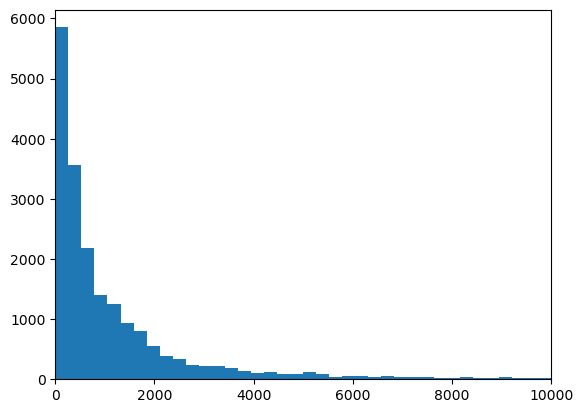

In [46]:
plt.hist(df['content'].apply(lambda x: len(x)), bins=1000)
plt.xlim(0,10000)
plt.show()

**`Generate Word Count Vector for the complete corpus`**

In [65]:
d = {}
for sent_tokens in df['sent_list']:
    for sent in sent_tokens:
        for word in sent.split():
            word = word.replace(".", "").strip()
            if word in d:
                d[word] += 1
            else:
                d[word] = 1

**`Create a column with sentences as list elements for each message in main dataframe`**

In [91]:
def sentence_tokenization(text):
    sentence_list = sent_tokenize(text)
    transformed_sent = []
    for sentence in sentence_list:
        transformed_sent.append(re.sub("[^a-zA-Z0-9 ]", "", sentence))
    return transformed_sent

In [92]:
df['sent_list'] = df['content'].apply(sentence_tokenization)

**`Sort Top N words by total count in the corpus `**

In [64]:
sorted(d.items(), key=lambda x: x[1], reverse=True)[:20]

[('the', 194347),
 ('to', 140013),
 ('and', 87514),
 ('a', 79911),
 ('of', 72795),
 ('in', 61234),
 ('you', 54237),
 ('for', 52873),
 ('is', 50794),
 ('on', 47504),
 ('i', 39791),
 ('this', 34549),
 ('that', 34048),
 ('not', 29304),
 ('be', 29176),
 ('will', 28690),
 ('from', 28524),
 ('with', 27117),
 ('at', 26695),
 ('have', 26266)]

***All Top20 words are Stopwords***

# Word Cloud

**`Build Word cloud from the email body texts`**

# Bigram Model

In [68]:
from nltk.util import bigrams, trigrams

**`Generate bigram dictionary with frequency of occurence in {(currentword, nextword): freq}`**

In [99]:
bi_dict = {}
for message in df['sent_list']:
    for sentence in message:
        for words in bigrams(sentence.split()):
            if words in bi_dict:
                bi_dict[words] += 1
            else:
                bi_dict[words] = 1            

**`Sort the dictinary based on key and values`**

In [101]:
sorted(bi_dict.items(), key=lambda x: x[0])

[(('0', '0'), 326),
 (('0', '00'), 19),
 (('0', '000'), 1),
 (('0', '000c05a6'), 2),
 (('0', '0067'), 3),
 (('0', '0077'), 3),
 (('0', '0200'), 4),
 (('0', '0214'), 3),
 (('0', '0250'), 6),
 (('0', '0286'), 6),
 (('0', '0333'), 3),
 (('0', '037'), 1),
 (('0', '0385'), 6),
 (('0', '0400'), 12),
 (('0', '0417'), 6),
 (('0', '0462'), 12),
 (('0', '0467'), 12),
 (('0', '05'), 1),
 (('0', '0500'), 20),
 (('0', '0533'), 9),
 (('0', '0538'), 6),
 (('0', '0571'), 3),
 (('0', '0583'), 6),
 (('0', '0600'), 11),
 (('0', '0615'), 3),
 (('0', '0643'), 3),
 (('0', '0667'), 6),
 (('0', '0700'), 2),
 (('0', '0733'), 9),
 (('0', '0769'), 3),
 (('0', '0800'), 2),
 (('0', '081001'), 1),
 (('0', '0833'), 3),
 (('0', '0846'), 3),
 (('0', '0857'), 3),
 (('0', '1'), 36),
 (('0', '10000'), 30),
 (('0', '12'), 3),
 (('0', '14'), 16),
 (('0', '15'), 2),
 (('0', '15000'), 6),
 (('0', '151001'), 1),
 (('0', '15540'), 1),
 (('0', '16'), 10),
 (('0', '1665625'), 1),
 (('0', '1728941603'), 3),
 (('0', '18'), 3),
 ((